# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv4_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version: v6 - Run with option to not use IN-CORE
- 2023-01-27 - Generalize workflow using new Lumberton Building Data
- 2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [16]:
# Do you want to use IN-CORE Dataservice? If yes, set to True
use_incore = False

In [2]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted
import scooby # Reports Python environment

# Check if using IN-CORE Dataservice
if use_incore:
    from pyincore import IncoreClient, Dataset, DataService

C:\Users\nathanael99\AppData\Local\Temp\ipykernel_16852\3545937410.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd # For reading in shapefiles


In [3]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_00e_geoutilities import spatial_join_points_to_poly
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions


In [4]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz','ipyleaflet']))


--------------------------------------------------------------------------------
  Date: Tue May 09 13:51:36 2023 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 15:53:35)
  [MSC v.1929 64 bit (AMD64)]

            pandas : 1.5.3
          pyincore : 1.8.0
      pyincore_viz : 1.8.1
        ipyleaflet : 0.17.2
             numpy : 1.24.2
             scipy : 1.10.0
           IPython : 8.10.0
        matplotlib : 3.6.3
            scooby : 0.7.1
--------------------------------------------------------------------------------


In [5]:
# Check working directory - good practice for relative path access
os.getcwd()

'\\\\filer.arch.tamu.edu\\staff\\nathanael99\\Downloads\\intersect-community-data-main\\intersect-community-data-main'

### Required Information: 
#### Residential Building Variable
What variable has information to determine if building is residential or not?
County observations by variable


In [6]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

Nofal_residential_archetypesv2 = { 
        1 : {'Description' : 
                'One-story sf residential building on a crawlspace foundation',
             'HU estimate' : 1},
        2 : {'Description' : 
                'One-story mf residential building on a slab-on-grade foundation',
              'HU estimate' : 1},
        3 : {'Description' : 
                'Two-story sf residential building on a crawlspace foundation',
            'HU estimate' : 1},
        4 : {'Description' : 
                'Two-story mf residential building on a slab-on-grade foundation',
            'HU estimate' : 1}
            }


# HAZUS Archetypes for residential buildings include an estimate of housing units
HAZUS_residential_archetypes = { 
    "RES1" : {'Description' : "Single Family Dwelling", 'HU estimate' : 1},
    "RES2" : {'Description' : "Mobile / Manufactured Home", 'HU estimate' : 1},
    "RES3A" : {'Description' : "Duplex", 'HU estimate' : 2},
    "RES3B" : {'Description' : "3-4 Units", 'HU estimate' : 3},
    "RES3C" : {'Description' : "5-9 Units", 'HU estimate' : 7},
    "RES3D" : {'Description' : "10-19 Units", 'HU estimate' : 15},
    "RES3E" : {'Description' : "20-49 Units", 'HU estimate' : 30},
    "RES3F" : {'Description' : "50+ Units", 'HU estimate' : 50},
    "RES4" : {'Description' : "Temporary Lodging", 'HU estimate' : 1},
    "RES5" : {'Description' : "Institutional Dormitory", 'HU estimate' : 1},
    "RES6" : {'Description' : "Nursing Home", 'HU estimate' : 1}
    }

In [7]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/

# NOTE on file path length. WINDOWS has a limit of 260 characters for file path length.
# Community name needs to be short to avoid this limit.

communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'focalplace_name' : 'Lumberton',
                    'STATE' : 'NORTH_CAROLINA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}},
                    'building_inventory' : { 
                        'id' : '62ab7dcbf328861e25ffea9e',
                        'note' : 'Building inventory for Robeson County, NC',
                        'archetype_var' : 'archetype',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }
communities = {'Galveston_TX' : {
                    'community_name' : 'Galveston, TX',
                    'focalplace_name' : 'Galveston',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48167', 'Name' : 'Galveston County, TX'}},
                    'building_inventory' : { 
                        'id' : '63053ddaf5438e1f8c517fed',
                        'note' : 'Building inventory for Galveston County, TX',
                        'archetype_var' : 'arch_flood',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }

version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [8]:
if use_incore:
    client = IncoreClient()
    # IN-CORE caches files on the local machine, it might be necessary to clear the memory
    client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.8.0


In [9]:
if use_incore:
    # create data_service object for loading files
    data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [17]:
generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder,
                    use_incore=     use_incore
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

# If using IN-CORE
if use_incore:
    # Housing Unit inventory
    housing_unit_inv_id = hui_dataset_id
    # load housing unit inventory as pandas dataframe
    housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
    filename = housing_unit_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

    # Convert CSV to Pandas Dataframe
    housing_unit_inv_df = pd.read_csv(filename, header="infer")
else:
    housing_unit_inv_df = hui_dataset_id

Generating Housing Unit Inventory v2.0.0 data for Galveston, TX
Galveston County, TX : county FIPS Code 48167
File already exists, skipping: OutputData/GalvestonCounty_TX/../hui_v2-0-0_Galveston_TX_2010_rs1000.csv


In [18]:
housing_unit_inv_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,vacancy,gqtype,incomegroup,hhinc,randincome,poverty
0,B481677201001000H001,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,0,0,6,3,31459.0,0.0
1,B481677201001000H002,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,0,0,6,3,34695.0,0.0
2,B481677201001000H003,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,0,0,7,3,38776.0,0.0
3,B481677201001000H004,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,0,0,10,3,52398.0,0.0
4,B481677201001000H005,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,0,0,11,3,69564.0,0.0


## Generate Address Point Inventory

In [12]:
for community in communities.keys():
    # Set parameters for Address point generation
    archetype_var = communities[community]['building_inventory']['archetype_var']
    building_area_var = communities[community]['building_inventory']['building_area_var']
    residential_archetypes = communities[community]['building_inventory']['residential_archetypes']
    # load building inventory
    # If using IN-CORE
    if use_incore:
        # Building inventory ID
        bldg_inv_id = communities[community]['building_inventory']['id']
        bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
        filename = bldg_inv.get_file_path('shp')
        print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)
        bldg_inv_gdf = gpd.read_file(filename)
    else:
        bldg_filename = communities[community]['building_inventory']['filename']
        bldg_inv_gdf = gpd.read_file(filename)


    print("Generate Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        archetype_var = archetype_var,
                        building_area_var = building_area_var,
                        building_area_cutoff = 300,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        use_incore=     use_incore
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

    ### Read in Address Point Inventory
    '''
    The address point inventory is an intermediate file based on the building inventory. 
    The address point inventory acts as the bridge between the building inventory 
    and the housing unit inventory.
    '''
    # Check if addpt_dataset_id is string
    if isinstance(addpt_dataset_id, str):
        print("The Address Point Inventory ID is a pandas string")
        # Address Point inventory
        addpt_inv_id = addpt_dataset_id
        # load housing unit inventory as pandas dataframe
        addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
        filename = addpt_inv.get_file_path('csv')
        print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
        addpt_inv_df = pd.read_csv(filename, header="infer")
    # else if addpt_dataset_id is a dataframe
    elif isinstance(addpt_dataset_id, pd.DataFrame):
        addpt_inv_df = addpt_dataset_id
        print("The Address Point Inventory ID contains a pandas dataframe")
    else:
        print("The Address Point Inventory is not a string or pandas dataframe")

    '''
    ### Run Housing Unit Allocation
    '''

    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_gdf = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders,
                        use_incore=     use_incore
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

    ## Merge Housing Unit Allocation with Housing Unit Inventory
    # Merge HUA with HUI
    hua_cols = ['huid','guid','placeNAME10','huestimate','x','y']
    hua_hui_df = pd.merge(left = housing_unit_inv_df,
                        right = hua_gdf[hua_cols],
                        on='huid',
                        how='left')

    # Replace missing guid 
    hua_hui_df['guid'] = hua_hui_df['guid'].fillna('missing building id')

    ## Save Housing Unit Allocation to CSV and Upload to IN-CORE Dataservice
    # save hua_hui_gdf to csv
    check_folder = outputfolder
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}_{bldg_inv_id}'
    csv_filepath = check_folder+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    # Resave results for community name
    hua_hui_df.to_csv(savefile, index=False)

    # make a county list for community
    county_list = ''
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
        county_list = county_list + state_county_name+': county FIPS Code '+state_county
    county_list
    
    title = "Housing Unit Allocation v2.0.0 data for "+community + " " + str(basevintage)
    title

    if use_incore:
        # Upload to IN-CORE Dataservice
        run_hua_gdf.upload_hua_file_to_incore(title =title,
                            county_list = county_list,
                            csv_filepath = csv_filepath,
                            output_filename = output_filename)

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63053ddaf5438e1f8c517fed\galveston_bldgs_w_guid\galveston_bldgs_w_guid.shp
Generate Address point inventory for: Galveston_TX
Based on building inventory: 63053ddaf5438e1f8c517fed
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Galveston_TX 2010
Connection successful to IN-CORE services. pyIncore version detected: 1.8.0
Number of datasets matching Address Point Inventory v2.0.0 data for Galveston_TX 2010: 0
Dataset Address Point Inventory v2.0.0 data for Galveston_TX 2010 does not exist in IN-CORE
***************
Obtaining Census Block, Place, and PUMA Data
***************

Galveston County, TX : county FIPS Code 48167
Creating folder OutputData/GalvestonCounty_TX to store output.
Creating folder OutputData/GalvestonCounty_TX/00_logfile

In [13]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                             210678
unique                                            210678
top       ST1815653a-7b70-44ce-8544-e975596bdf82AP000000
freq                                                   1
Name: addrptid, dtype: object

## Explore and Validate Housing Unit Allocation


In [14]:
hua_gdf.head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,placeNAME10,x,y,archetype,geometry
0,B481677201001000H001,481677201001000,4.816772e+14,4.816772e+11,4.816772e+10,48167.0,1.0,1.0,1.0,0.0,...,1.0,ST2290ae5b-99e1-46d2-b6cb-f4dde1c2ed51AP000000,2290ae5b-99e1-46d2-b6cb-f4dde1c2ed51,1.0,1.0,Friendswood,-95.202090,29.556617,0.0,POINT (-95.20209 29.55662)
1,B481677201001000H002,481677201001000,4.816772e+14,4.816772e+11,4.816772e+10,48167.0,1.0,1.0,1.0,0.0,...,1.0,ST3c985a93-c848-40c8-835a-85184f69bbb4AP000000,3c985a93-c848-40c8-835a-85184f69bbb4,1.0,1.0,Friendswood,-95.215403,29.554199,0.0,POINT (-95.21540 29.55420)
2,B481677201001000H003,481677201001000,4.816772e+14,4.816772e+11,4.816772e+10,48167.0,1.0,1.0,1.0,0.0,...,1.0,ST7c6fe5f4-d96a-4304-8267-7a1dcde7ec91AP000000,7c6fe5f4-d96a-4304-8267-7a1dcde7ec91,1.0,1.0,Friendswood,-95.211325,29.557518,0.0,POINT (-95.21133 29.55752)
3,B481677201001000H004,481677201001000,4.816772e+14,4.816772e+11,4.816772e+10,48167.0,1.0,1.0,1.0,0.0,...,1.0,ST314a358e-186c-4a6b-9e41-d15edf4adb95AP000000,314a358e-186c-4a6b-9e41-d15edf4adb95,1.0,1.0,Friendswood,-95.210067,29.555272,0.0,POINT (-95.21007 29.55527)
4,B481677201001000H005,481677201001000,4.816772e+14,4.816772e+11,4.816772e+10,48167.0,1.0,1.0,1.0,0.0,...,1.0,STb1a887d1-b151-4bce-b555-da24e0dabbf5AP000000,b1a887d1-b151-4bce-b555-da24e0dabbf5,1.0,1.0,Friendswood,-95.208705,29.557569,0.0,POINT (-95.20871 29.55757)


In [15]:
hua_gdf.head(1).T

,0
huid,B481677201001000H001
Block2010,481677201001000
blockid,481677201001000.0
bgid,481677201001.0
tractid,48167720100.0
FIPScounty,48167.0
numprec,1.0
ownershp,1.0
race,1.0
hispan,0.0


In [16]:
# describe the housing unit allocation primary keys and foreign keys
hua_gdf[['huid','Block2010','addrptid','guid','strctid']].astype(str).describe().T

,count,unique,top,freq
huid,197527,132554,nan,64974
Block2010,197527,6028,999999999999999,64974
addrptid,197527,132554,nan,64974
guid,197527,172535,nan,566
strctid,197527,107675,nan,64974


### Look at population characteristics and compare to US Census

In [17]:
# convert hui_hua_df to geodataframe
crs = "EPSG:4326"
hua_hui_gdf = gpd.GeoDataFrame(hua_hui_df, 
    geometry=gpd.points_from_xy(hua_hui_df.x, hua_hui_df.y), crs=crs)

In [22]:
from pyncoda.ncoda_04c_poptableresults import *
from pyncoda.ncoda_00d_cleanvarsutils import *

In [40]:
communities

{'Galveston_TX': {'community_name': 'Galveston, TX',
  'focalplace_name': 'Galveston',
  'STATE': 'TEXAS',
  'years': ['2010'],
  'counties': {1: {'FIPS Code': '48167', 'Name': 'Galveston County, TX'}},
  'building_inventory': {'id': '63053ddaf5438e1f8c517fed',
   'note': 'Building inventory for Galveston County, TX',
   'archetype_var': 'arch_flood',
   'residential_archetypes': {1: {'Description': 'One-story sf residential building on a crawlspace foundation',
     'HU estimate': 1},
    2: {'Description': 'One-story mf residential building on a slab-on-grade foundation',
     'HU estimate': 1},
    3: {'Description': 'Two-story sf residential building on a crawlspace foundation',
     'HU estimate': 1},
    4: {'Description': 'Two-story mf residential building on a slab-on-grade foundation',
     'HU estimate': 1}},
   'building_area_var': 'sq_foot'}}}

In [42]:
where = communities[community]['community_name']
focalplace = communities[community]['focalplace_name']
countyfips = communities[community]['counties'][county]['FIPS Code']
countyname = communities[community]['counties'][county]['Name']
print(where, focalplace, countyname, countyfips)

Galveston, TX Galveston Galveston County, TX 48167


In [43]:
PopResultsTable.pop_results_table(
                  input_df = hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = countyname,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","137,132 (67.3%)","37,790 (46.2%)","174,922 (61.3%)"
"2 Black alone, Not Hispanic","19,133 (9.4%)","18,286 (22.4%)","37,419 (13.1%)"
"3 American Indian and Alaska Native alone, Not Hispanic",745 (0.4%),360 (0.4%),"1,105 (0.4%)"
"4 Asian alone, Not Hispanic","6,304 (3.1%)","1,717 (2.1%)","8,021 (2.8%)"
"5 Other Race, Not Hispanic","2,000 (1.0%)",931 (1.1%),"2,931 (1.0%)"
"6 Any Race, Hispanic","38,504 (18.9%)","22,633 (27.7%)","61,137 (21.4%)"
Total,"203,818 (100.0%)","81,717 (100.0%)","285,535 (100.0%)"


In [47]:
focalplace_hua_hui_gdf = hua_hui_gdf.loc[hua_hui_gdf['placeNAME10'] == focalplace].copy(deep=True)
focalplace_hua_hui_gdf.head(1).T

,13995
huid,B481677240001010H001
blockid,481677240001010
bgid,481677240001
tractid,48167724000
FIPScounty,48167
numprec,1
ownershp,2.0
race,1.0
hispan,0.0
family,0.0


In [48]:
PopResultsTable.pop_results_table(
                  input_df = focalplace_hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","12,015 (54.0%)","8,617 (37.9%)","20,632 (45.9%)"
"2 Black alone, Not Hispanic","2,716 (12.2%)","5,382 (23.7%)","8,098 (18.0%)"
"3 American Indian and Alaska Native alone, Not Hispanic",73 (0.3%),118 (0.5%),191 (0.4%)
"4 Asian alone, Not Hispanic",606 (2.7%),784 (3.4%),"1,390 (3.1%)"
"5 Other Race, Not Hispanic",221 (1.0%),300 (1.3%),521 (1.2%)
"6 Any Race, Hispanic","6,611 (29.7%)","7,533 (33.1%)","14,144 (31.4%)"
Total,"22,242 (100.0%)","22,734 (100.0%)","44,976 (100.0%)"


In [49]:
# add category for missing building id
buildingdata_conditions = {'cat_var' : {'variable_label' : 'Building Data Availability',
                         'notes' : 'Does Housing Unit have building data?'},
              'condition_list' : {
                1 : {'condition': "(df['guid'] == 'missing building id')", 'value_label': "0 Missing Building Data"},
                2 : {'condition': "(df['guid'] != 'missing building id')", 'value_label': "1 Building Data Available"}}
            }
hua_hui_gdf = add_label_cat_conditions_df(hua_hui_gdf, conditions = buildingdata_conditions)

0 Missing Building Data had 566 observations
1 Building Data Available had 131987 observations


In [51]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

Building Data Availability_str,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Race Ethnicity,,,,
"1 White alone, Not Hispanic",409 (44.9%),"174,513 (60.4%)","174,922 (60.4%)",0.2%
"2 Black alone, Not Hispanic",62 (6.8%),"37,357 (12.9%)","37,419 (12.9%)",0.2%
"3 American Indian and Alaska Native alone, Not Hispanic",4 (0.4%),"1,101 (0.4%)","1,105 (0.4%)",0.4%
"4 Asian alone, Not Hispanic",27 (3.0%),"7,994 (2.8%)","8,021 (2.8%)",0.3%
"5 Other Race, Not Hispanic",2 (0.2%),"2,929 (1.0%)","2,931 (1.0%)",0.1%
"6 Any Race, Hispanic",66 (7.3%),"61,071 (21.1%)","61,137 (21.1%)",0.1%
7 Group Quarters no Race Ethnicity Data,340 (37.4%),"3,957 (1.4%)","4,297 (1.5%)",7.9%
Total,910 (100.0%),"288,922 (100.0%)","289,832 (100.0%)",0.3%


In [52]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Group Quarters Type",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

Building Data Availability_str,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Group Quarters Type,,,,
0. NA (non-group quarters),570 (62.6%),"284,965 (98.6%)","285,535 (98.5%)",0.2%
1 Correctional facilities for adults,nan (nan%),"1,611 (0.6%)","1,611 (0.6%)",nan%
2. Juvenile facilities,29 (3.2%),103 (0.0%),132 (0.0%),22.0%
3. Nursing facilities/Skilled-nursing facilities,278 (30.5%),900 (0.3%),"1,178 (0.4%)",23.6%
4. Other institutional facilities,nan (nan%),7 (0.0%),7 (0.0%),nan%
5. College/University student housing,nan (nan%),917 (0.3%),917 (0.3%),nan%
6. Military quarters,nan (nan%),36 (0.0%),36 (0.0%),nan%
7. Other noninstitutional facilities,33 (3.6%),383 (0.1%),416 (0.1%),7.9%
Total,910 (100.0%),"288,922 (100.0%)","289,832 (100.0%)",0.3%


In [53]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                   who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$78,688","$56,319","$72,487"
"2 Black alone, Not Hispanic","$42,419","$31,080","$37,191"
"3 American Indian and Alaska Native alone, Not Hispanic","$55,344","$48,630","$51,167"
"4 Asian alone, Not Hispanic","$71,109","$43,866","$64,160"
"5 Other Race, Not Hispanic","$59,184","$50,653","$56,363"
"6 Any Race, Hispanic","$54,308","$41,168","$49,128"
Total,"$69,781","$46,305","$61,807"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community
should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

In [54]:
print("Total Population by Race and Ethnicity:")
print(f"https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=DECENNIALSF12010.P5")

print("Median Income by Race and Ethnicity:")
print(f"All Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013")
print(f"Black Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013B")
print(f"White, not Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013H")
print(f"Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013I")

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?g=0500000US48167&tid=DECENNIALSF12010.P5
Median Income by Race and Ethnicity:
All Households: https://data.census.gov/cedsci/table?g=0500000US48167&tid=ACSDT5Y2012.B19013
Black Households: https://data.census.gov/cedsci/table?g=0500000US48167&tid=ACSDT5Y2012.B19013B
White, not Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US48167&tid=ACSDT5Y2012.B19013H
Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US48167&tid=ACSDT5Y2012.B19013I


Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

## Explore the HUA Results

In [55]:
# add race ethnicity to data frame
hua_hui_race_gdf = PopResultsTable.add_race_ethnicity_to_pop_df(hua_hui_gdf)

### Save map

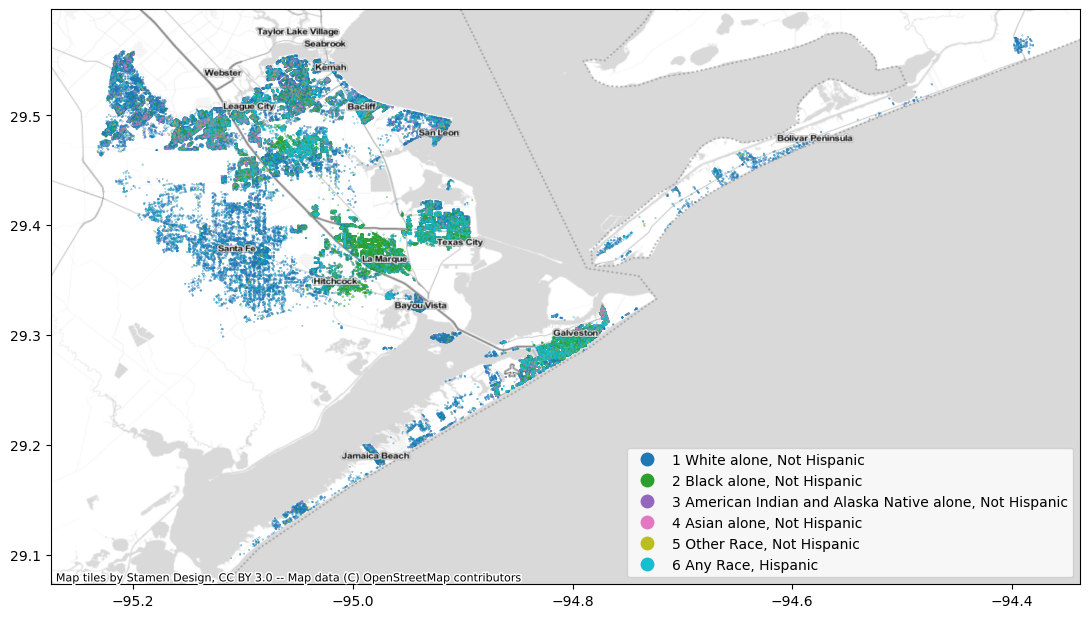

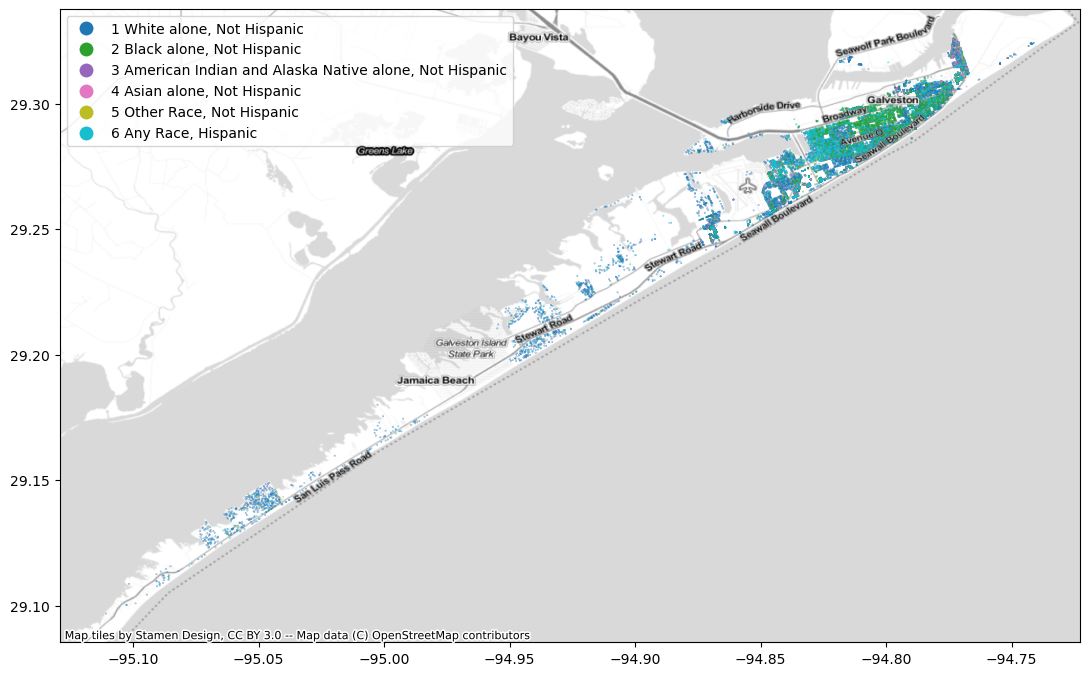

In [56]:
import contextily as cx # For adding basemap tiles to plot
import matplotlib.pyplot as plt # For plotting and making graphs

condition1 = "(hua_hui_race_gdf.race >= 1)"
place = focalplace
condition2 = f"(hua_hui_race_gdf.placeNAME10 == '{place}')"

condition_list = {1 : f"{condition1}",
                  2 : f"{condition1} & {condition2}" 
                } 

for item in condition_list.keys():
    condition =  condition_list[item]
    # Obtain data
    popdata = hua_hui_race_gdf.loc[eval(condition)].copy(deep=True)
    hua_data = popdata.to_crs(epsg=4326)

    # Set save file
    mapname = 'racedotmap'
    # save hua_hui_gdf to csv
    check_folder = f"{outputfolder}/{community}/06_Explore"
    output_filename = f'{mapname}_{community}_{place}'
    filepath = check_folder+"/"+output_filename

    ''' Need to sort out figure and axes
    # Set figure size (width, height) in inches
    #plt.figure(figsize = ( 14 , 12 ))
    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    # Figure Title
    by_label = "Race Ethnicity"
    who = f"Housing Unit Locations"
    what = f"by {by_label}"
    where = "Lumberton, NC"
    when = "2010"
    table_title = who +" "+ what+", \n "+ where +", "+ when +"."


    # Set title for figure
    plt.title( table_title, size = 18)

    notes = "notes here"
    plt.gcf().text(0, 0, notes, 
                            va = 'bottom', ha='left',
                            fontstyle='italic', size=6)
    '''

    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True
    
    # Plot the data
    ax = hua_data.plot(column='Race Ethnicity',
                        categorical=True, 
                        legend=True, 
                        markersize = 0.05)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLabels)

    ax.figure.savefig(filepath+'v2.svg', 
                bbox_inches="tight",format = 'svg', 
                dpi=600)

    ax.figure.savefig(filepath+'v2.png', 
                bbox_inches="tight",format = 'png', 
                dpi=600)
